In [1]:
# import libraries
from distutils.log import error
from gc import callbacks
from turtle import color
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import imblearn
import os

# Question 1: Briefly discuss why it is more difficult to find a good classifier on imbalanced dataset

In case that the dataset is imbalanced between the fraudulent and non-fraudulent cases, it would be difficult to find a good classifier mainly because it is difficult to assess the real performance of the models. If only 1% of the observations are fraudulent, in case the model just process with random guessing prediction of being all non-fraudulent, the accuracy of the model would still be 99%, which is really high. However, this high accuracy is highly dependent to the dataset instead of the model itself. Therefore, when the number of observations of each type is more balanced, it would be easier to assess the prediction performance of the model.

# Question 2: Data Cleaning and Feature Engineering

The main cleaning process to the dataset consists of:
1. Remove the  8 duplicate rows of the dataset, since they do not provide any additional information to the classification task.
2. Check the unique values within the columns, which in this case, none of them presents the same value across all the rows.
3. Drop the column called "InsurerNotes", which is free text regarding the incidence. In this case, we will not include this information to the classfication model. 
4. Check the NA values of the dataset and fill the categorical variables with string "None". For the numerical variables, we have decided to separate the dataset into fraud and non-fraud policy holders and verify if the numerical variables between them present any big differences. The main reason behind is to make sure that the fill NA process will not affect the pattern and characteristics of each type of policy holders, which the statistics showed that they were not the same.
5. Drop of 3 rows within the variable "FpVehicleAgeMonth" since their values were negative and from the description of this variable, we considered that it would be better to not include them into the classification model.

After the cleaning of the datasets, we concated them together again to proceed with feature engineering, which mainly consists of: 

1. Change the date related columns "LossDate" and "FirstPolicySubscriptionDate" into datetime format and then, into timestamp in order to be able to fit within the classification model afterwards. 
2. Convert all the categorical variables into dummy variables to fit within the model. 
3. In terms of the column "ClaimInvolvedCovers", after verifying the 191 unique values of the column, we have discovered that it contains all the type of policy covers that holders have used. In the case we create dummy variables for all the unique values, the number of columns would increase drastically. Hence, we have considered that it would be more useful to separate these type of covers into different columns and record all the users that have used them. Therefore, we created 14 new columns with the policy cover names and their values will be binary, being 1 if the client has used it and 0 otherwise. After this process, we would delete the original column since the information provided is overlapped.

In [2]:
# Read file
df = pd.read_csv('Insurance_claims.csv')

### Q2-1 Check duplicated rows

In [3]:
#check each row  of the dataset if duplicated
dups = df.duplicated() 
print(df[dups]) # 8 rows are duplicated
df.drop_duplicates(inplace=True)
print(df.shape) # (11522,24)


       PolicyholderNumber  FirstPartyVehicleNumber  ThirdPartyVehicleNumber  \
3451               564020                 754834.0                      NaN   
3452               564020                 754834.0                      NaN   
4281               724264                 968515.0                1007345.0   
4814               550279                 739198.0                1022681.0   
6191               336660                 510694.0                      NaN   
8449               564665                1010712.0                      NaN   
10594              608685                 810142.0                      NaN   
10958              741119                1005423.0                1187501.0   

                                            InsurerNotes  \
3451                                                 NaN   
3452                                                 NaN   
4281                                                 NaN   
4814                                            

### Q2-2 Check unique column of the dataset

In [4]:
# check the unique values within the columns
df.nunique()

PolicyholderNumber                 9404
FirstPartyVehicleNumber            9431
ThirdPartyVehicleNumber             350
InsurerNotes                       9040
PolicyholderOccupation               11
LossDate                            804
FirstPolicySubscriptionDate        1389
ClaimCause                           18
ClaimInvolvedCovers                  68
DamageImportance                      2
FirstPartyVehicleType                 4
ConnectionBetweenParties              5
PolicyWasSubscribedOnInternet         2
NumberOfPoliciesOfPolicyholder       17
FpVehicleAgeMonths                  388
EasinessToStage                       4
ClaimWihoutIdentifiedThirdParty       2
ClaimAmount                        8248
LossHour                             24
PolicyHolderAge                      73
NumberOfBodilyInjuries                6
FirstPartyLiability                   3
Fraud                                 2
LossAndHolderPostCodeSame             2
dtype: int64

### Q2-3 Drop column

In [5]:
df = df.drop(columns=['InsurerNotes'])

### Q2-4 Check NA values and Fill NA

In [6]:
# Check the NA values of the dataset
df.isna().sum()

PolicyholderNumber                     0
FirstPartyVehicleNumber              495
ThirdPartyVehicleNumber            11146
PolicyholderOccupation               342
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           193
ClaimInvolvedCovers                  191
DamageImportance                   10784
FirstPartyVehicleType                 12
ConnectionBetweenParties           11424
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
Fraud                                  0
LossAndHolderPostCodeSame              0
dtype: int64

In [7]:
# Fill categorical variables with string 'None'
df['FirstPartyVehicleNumber'].fillna('None',inplace=True)
df['ThirdPartyVehicleNumber'].fillna('None',inplace=True)
df['DamageImportance'].fillna('None',inplace=True)
df['PolicyholderOccupation'].fillna('None',inplace=True)
df['ClaimCause'].fillna('None',inplace=True)
df['ClaimInvolvedCovers'].fillna('None',inplace=True)
df['FirstPartyVehicleType'].fillna('None', inplace=True)
df['ConnectionBetweenParties'].fillna('None', inplace=True)

In [8]:
# Drop 3 rows which the values were negative
df.drop(df[df['FpVehicleAgeMonths'] <0 ].index,inplace=True)

In [9]:
# separate two subset
# Fraud Subset and get the mean of the numerical variables
df_fraud = df[df['Fraud'] ==1]
df_fraud.mean()

<ipython-input-9-770cd0c753ef>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fraud.mean()


PolicyholderNumber                 539728.982609
PolicyWasSubscribedOnInternet           0.304348
NumberOfPoliciesOfPolicyholder          1.608696
FpVehicleAgeMonths                    116.778761
EasinessToStage                         0.343043
ClaimWihoutIdentifiedThirdParty         0.565217
ClaimAmount                          3633.061652
LossHour                               12.885965
PolicyHolderAge                        40.678261
NumberOfBodilyInjuries                  0.034783
FirstPartyLiability                     0.486957
Fraud                                   1.000000
LossAndHolderPostCodeSame               0.626087
dtype: float64

In [10]:
# Non Fraud Subset and get the mean of the numerical variables
df_nonfraud = df[df['Fraud'] ==0]
df_nonfraud.mean()

<ipython-input-10-1db0961a6356>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_nonfraud.mean()


PolicyholderNumber                 487900.936338
PolicyWasSubscribedOnInternet           0.204314
NumberOfPoliciesOfPolicyholder          2.238250
FpVehicleAgeMonths                    113.459628
EasinessToStage                         0.378021
ClaimWihoutIdentifiedThirdParty         0.687040
ClaimAmount                          1387.702325
LossHour                                8.222262
PolicyHolderAge                        44.610925
NumberOfBodilyInjuries                  0.027973
FirstPartyLiability                     0.205279
Fraud                                   0.000000
LossAndHolderPostCodeSame               0.565942
dtype: float64

In [11]:
# Fill the NA values of numerical variables with mean in each class
df_fraud['FpVehicleAgeMonths'].fillna(df_fraud['FpVehicleAgeMonths'].mean(),inplace=True)
df_fraud['LossHour'].fillna(df_fraud['LossHour'].mean(),inplace=True)

df_nonfraud['FpVehicleAgeMonths'].fillna(df_nonfraud['FpVehicleAgeMonths'].mean(),inplace=True)
df_nonfraud['LossHour'].fillna(df_nonfraud['LossHour'].mean(),inplace=True)
df_nonfraud['PolicyHolderAge'].fillna(df_nonfraud['PolicyHolderAge'].mean(),inplace=True)


/Users/xiawang/opt/anaconda3/envs/DT/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [12]:
# Concat two subsets again
df= pd.concat([df_fraud,df_nonfraud])

### Q2-5 Feature Engineering

In [13]:
# Change the time related column into datatime and then to timestamp (LossDate,FirstPolicySubscriptionDate)
from datetime import datetime
df['LossDate'] = pd.to_datetime(df['LossDate'])
df['FirstPolicySubscriptionDate'] = pd.to_datetime(df['FirstPolicySubscriptionDate'])

df['LossDate'] =df['LossDate'].apply(lambda x: datetime.timestamp(x)) 
df ['FirstPolicySubscriptionDate']= df ['FirstPolicySubscriptionDate'].apply(lambda x: datetime.timestamp(x))

In [14]:
# Convert all the categorical variables into dummies 
# using apply lambda function to iterate each rows 
df['FirstPartyVehicleNumber'] =df['FirstPartyVehicleNumber'].apply(lambda x: "Yes" if x!= 'None' else x )
df['ThirdPartyVehicleNumber'] =df['ThirdPartyVehicleNumber'].apply(lambda x: "Yes" if x!= 'None' else x )

# get dummy variables
df = pd.get_dummies(df, drop_first = True, columns = ['FirstPartyVehicleNumber'])
df = pd.get_dummies(df, drop_first = True, columns = ['ThirdPartyVehicleNumber'])
df = pd.get_dummies(df,drop_first=True, columns = ['PolicyholderOccupation'])
df = pd.get_dummies(df,drop_first=True, columns = ['ClaimCause'])
df = pd.get_dummies(df, drop_first = True, columns = ['DamageImportance'])
df = pd.get_dummies(df, drop_first = True, columns = ['FirstPartyVehicleType'])
df = pd.get_dummies(df, drop_first = True, columns = ['ConnectionBetweenParties'])


In [15]:
# Separate each type of covers to different columns in terms of the ClaimInvolvedCovers column
df_count = df['ClaimInvolvedCovers'].str.split(" ", expand=True).apply(pd.value_counts)
lst = list(df_count.index)
lst

for cover in lst:
    df[cover] = df['ClaimInvolvedCovers'].apply(lambda x: 1 if (cover in x) else 0)

df.drop(columns=['ClaimInvolvedCovers'],inplace=True)

In [16]:
df.shape

(11519, 71)

# Q3: Creating Deep Neural Network on Imbalanced Dataset (Model 3)

In this section, we are going to split the dataset into train, validation and test, scale them before running the model.

In [17]:
from sklearn.model_selection import train_test_split

y= df['Fraud']
X = df.drop(columns= ['Fraud','PolicyholderNumber'])

In [23]:
# Splitting the data into training and testing set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)

In [24]:
# Scale the X-training data and then use the same scaler on the test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Split train to train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=888)

## Q3.1 Building a Neural Network

In this section, we are going to load the TensorBoard to display the metrics that we have obtained in with each combination of hyperparameters.

In [33]:
# Load TensorBoard Extension
%load_ext tensorboard
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
from tensorboard.plugins.hparams import api as hp

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# create a folder loading results first
rm -rf ./logs/

## Q3.2 Using HParams and TensorBoard

In this section, we set the ranges of each hyperparameters to combine and find the best model with the highest accuracy.

- The structure of Model 3 will be of 1 input layer, 1 hidden layer and 1 output layer.
- The main optimizers are between SGD and Adam, which will be combined randomly with the hyperparameters. 
- The learning rate is set to be between 0.001 to 0.1. 
- The number of neurons in the hidden layer is set to be between 10 to 30. 
- The main metric to assess the performance will be the accuracy. 
- We have set an early stopping callback to the model, so that the machine will stop automatically when the validation loss stops decreasing after 10 epochs.

The session will be run 10 times, which once finished, we could load the results to the TensorBoard to see performance of each run model. 


In [36]:
#%% Using HParams, define the parameters, as well as the interval over
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete(range(10,30)))

METRIC_ACC = 'accuracy'

In [37]:
# Write parameters and metrics into our folder with the logs
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LEARNING_RATE, HP_OPTIMIZER, HP_NUM_UNITS], 
                      metrics = [hp.Metric(METRIC_ACC, display_name='ACC')])

2022-03-09 03:20:24.493222: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
# clear TensorFlow session 
tf.keras.backend.clear_session()
np.random.seed(888)
tf.random.set_seed(888)

In [47]:
# Define function of tuning parameter to train and evaluate the model 
def train_test_model3(hparams, run_dir):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu"),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    if hparams[HP_OPTIMIZER] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE],clipvalue=1)
    elif hparams[HP_OPTIMIZER] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
        
    model.compile(  optimizer=optimizer,
                    loss='binary_crossentropy', 
                    metrics=METRIC_ACC)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping_cb])
    acc = model.evaluate(X_valid, y_valid)[1]

    
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        tf.summary.scalar(METRIC_ACC, acc, step=1) 

In [ ]:
total_sessions = 10

for session in range(total_sessions):
    
    # Create hyperparameters randomly
    num_units = HP_NUM_UNITS.domain.sample_uniform()
    optimizer = HP_OPTIMIZER.domain.sample_uniform()
    
    r = -3*np.random.rand()
    learning_rate = 10.0**r
    
    # Create a dictionary of hyperparameters
    hparams = { HP_LEARNING_RATE: learning_rate,
                HP_OPTIMIZER: optimizer,
                HP_NUM_UNITS: num_units}
    
    # train the model with the chosen parameters
    run_name = "run-%d" % session
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    train_test_model3(hparams,'logs/hparam_tuning/' + run_name)

## Q3.3 Visualization with TensorBoard

In [41]:

%tensorboard --logdir logs #run the TensorBoard

Reusing TensorBoard on port 6006 (pid 52699), started 0:17:44 ago. (Use '!kill 52699' to kill it.)

Run the neural network with the best accuracy showed in the TensorBoard.

In [51]:
# Applying the results obtained from TensorBoard
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
        ])
    
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.025099)

# Compile the model3 
model3.compile(  optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
                
# train the model3
log3 = model3.fit(X_train, y_train, epochs=100,
                     validation_data=(X_valid, y_valid))

Epoch 1/100
216/216 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.9808 - val_loss: 0.0534 - val_accuracy: 0.9918
Epoch 2/100
216/216 [==============================] - 1s 2ms/step - loss: 0.0607 - accuracy: 0.9894 - val_loss: 0.0491 - val_accuracy: 0.9918
Epoch 3/100
216/216 [==============================] - 1s 3ms/step - loss: 0.0592 - accuracy: 0.9894 - val_loss: 0.0482 - val_accuracy: 0.9918
Epoch 4/100
216/216 [==============================] - 1s 2ms/step - loss: 0.0586 - accuracy: 0.9894 - val_loss: 0.0478 - val_accuracy: 0.9918
Epoch 5/100
216/216 [==============================] - 1s 2ms/step - loss: 0.0580 - accuracy: 0.9894 - val_loss: 0.0473 - val_accuracy: 0.9918
Epoch 6/100
216/216 [==============================] - 1s 3ms/step - loss: 0.0575 - accuracy: 0.9894 - val_loss: 0.0470 - val_accuracy: 0.9918
Epoch 7/100
216/216 [==============================] - 1s 2ms/step - loss: 0.0570 - accuracy: 0.9894 - val_loss: 0.0466 - val_accuracy: 0.9918

In [52]:
# save model3.h5 file
# model3.save("my_tf_best_model3.h5")

In [62]:
# load the best model 3 
saved_model3= tf.keras.models.load_model("my_tf_best_model3.h5")

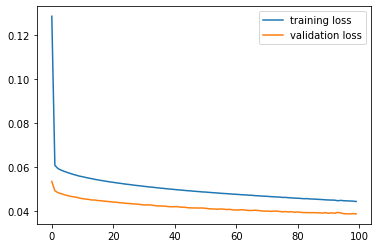

In [54]:
#Plot training loss and validation loss
plt.plot(log3.history['loss'],label = "training loss")
plt.plot(log3.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

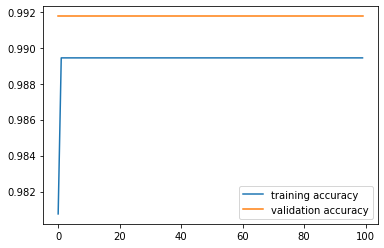

In [55]:
#Plot training accuracy and validation accuracy
plt.plot(log3.history['accuracy'],label = "training accuracy")
plt.plot(log3.history['val_accuracy'], label = "validation accuracy")
plt.legend()
plt.show()

## Q3.4 Evaluate Model on the Test set

In [63]:
# Get th probability of the y label in validation set
y_prob3 = saved_model3.predict(X_valid)

AUC test:  0.8773926062420823


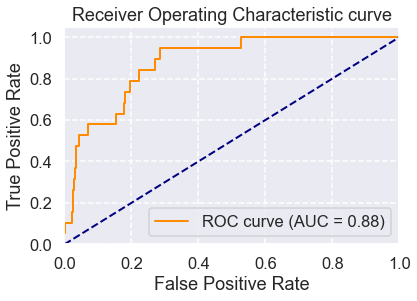

In [64]:
# Draw the ROC curve and calculate AUC score
fpr, tpr, thr = roc_curve(y_valid, y_prob3)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [65]:
# Find the threshold based on the J statistic
J3 = tpr - fpr
print("The best threshold according to the J statistic is " + str(thr[np.argmax(J3)]))


The best threshold according to the J statistic is 0.011238188


In [66]:
# Get the prediction of the y label based on the J statistic in validation dataset
y_predict_valid3= np.where(y_prob3 > thr[np.argmax(J3)], 1, 0)

# Get the confusion matrix of the prediction within validation dataset
cm3_valid = confusion_matrix(y_valid, y_predict_valid3)
cm3_valid

array([[1636,  649],
       [   2,   17]])

In [67]:
# To see the prediction accuracy of the model within validation dataset 
TN = cm3_valid[0][0]
FP= cm3_valid[0][1]
FN = cm3_valid[1][0]
TP= cm3_valid[1][1]
(TP + TN)/(TP +TN + FP + FN )

0.7174479166666666

In [68]:
# Evaluate the model on test set
saved_model3.evaluate(X_test, y_test)

72/72 [==============================] - 0s 1ms/step - loss: 0.0458 - accuracy: 0.9900


[0.045779261738061905, 0.9900173544883728]

In [69]:
# Get the probability of the y label on the testing set
y_prob_test3 = saved_model3.predict(X_test)

In [71]:
# Get the prediction of the y label based on the J statistic in testing set
y_predict_test3= np.where(y_prob_test3 > thr[np.argmax(J3)], 1, 0)
cm3_test = confusion_matrix(y_test, y_predict_test3)
cm3_test 

array([[1627,  654],
       [   3,   20]])

In [72]:
# To see the prediction accuracy of the model within test dataset 
TN = cm3_test[0][0]
FP= cm3_test[0][1]
FN = cm3_test[1][0]
TP= cm3_test[1][1]
(TP + TN)/(TP +TN + FP + FN )

0.71484375

## Q3.5 Briefly discuss the issues observed based on the metrics


Model 3 parameters:
- Number of neurons in the input layer: 69
- Number of neurons in the hidden layer: 20
- Number of hidden layers: 1
- Number of neurons in the output layer: 1
- Optimizer: SGD, Learning rate: 0.025099
- Metrics: Accuracy


We can observe that the accuracy of the model3 is around 71% in the test set. The AUC score we obtained is 88%, which indicates that our model presents a good performance in terms of prediction. However, we have to take into account that the dataset is imbalanced, with large number of non-fraud cases, which will lead to a high accuracy in terms of prediction. If we look at the confusion matrix of the model, it has managed to predict the majority of the positive fraud cases, but at the same time, it has considered large number of non-fradulent cases as fraudulent, which will also lead to creation of costs to the insurance company. As mentioned at the beginning of the file, when the dataset is imbalanced, it is hard to assess the performance of a model with the accuracy since it is higly influenced by the nature of the dataset implemented.

# Q4. SMOTE

As mentioned previously, it is difficult to find a good classifier when the dataset is extremely imbalanced, such as this case. Therefore, one of the approaches is to apply the SMOTE and undersampling methods to the dataset. The general idea of this process consists of recreating more fraudulent datapoints from the existing ones and, at the same time, reduce the number of datapoints of non-fraudulent classes in order to obtain a more balanced dataset. 

Firstly, we have split the original datatset into train and test. The test set will remain unmodified and just the train set will go through the SMOTE process. The proportion saved to test set is 20%, and from the rest 80% we will split into train and validation set after the SMOTE and undersampling process. 

We consider that keeping the real datapoints collected as much as possible would be better for the real implementation of the model. Therefore, we did not set the proportions of 50-50% between the classes after the SMOTE. We have decided to create fraudulent datapoints to represent 20% of the minority class and after the undersampling process, the proportion of fraudulent cases is 33.3% in the training set before splitting.

In [18]:
# Splitting into training and testing set
X_train5, X_test5, y_train5, y_test5 = train_test_split(X,y,test_size= 0.2, random_state=888)
np.sum(y_test5)

23

In [19]:
# Scale the X-training data and then use the same scaler on the test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train5 = scaler.fit_transform(X_train5)
X_test5 = scaler.transform(X_test5)

In [20]:
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.2, random_state = 888)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state = 241)
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_synth, y_synth = pipeline.fit_resample(X_train5, y_train5)

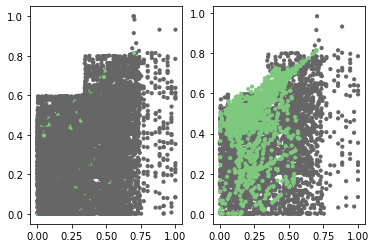

In [21]:
# visualise the process
plt.subplot(1,2,1)
plt.scatter(X_train5[:, 0], X_train5[:, 1], c=y_train5, s=10, cmap="Accent_r")
plt.subplot(1,2,2)
plt.scatter(X_synth[:, 0], X_synth[:, 1], c=y_synth, s=10, cmap="Accent_r")

In [22]:
# Split into train and validation dataset
X_train5, X_valid5, y_train5, y_valid5 = train_test_split(X_synth,y_synth, test_size= 0.25, random_state=888)
print(X_valid5.shape)
print(X_train5.shape)

(1368, 69)
(4104, 69)


# Q5. Creating a New Neural Network on Enhanced Dataset (Model 5)

After the implementation of SMOTE and undersampling to the dataset, we have ended up with a more balanced data where the number of observations per class is more equivalent than before. Under this situation, it would be easier for us to determine whether our model is performing well in terms of fraud detection and trust more on the metrics obtained, since the bias from dataset has been decreased as well as its influence on the prediction results. This means that, we might see a decrease in the accuracy rate, which was previously overfitted by the large non-fraudulent clients in Model 3. 

We will use the tuner Hyperband to choose the best parameters for the Model 5:
- Number of hidden layers: 2
- Number of neurons in the hidden layer: 7
- Number of neurons in the output layer: 1
- Number of neurons in the input layer: 69
- Optimizer: Adam, Learning rate: 0.00204


After the implementation of the new neural network model to the original test set that we split, we obtain an AUC score of around 77% and an accuracy of 87%, which is higher than Model 3, showing the good prediction performance of this model. Compared with our expectations, the false positive rate decreased, meaning that, the model make less erros when assigning non-fraudulent claims as fradulent.

By comparing the results between Model 3 and 5, we could see that once the dataset is more balanced, the model is able to learn more regarding the patterns and charasteristics of fraudulent cases than before, which has caused the decrease in the false positive rate. 

The model can still be improved by trying more number of combinations between the different hyperparameters, such as dropout rate, the activation functions, or by adding more hidden layers. However, we consider that the number of hidden layers should be kept under 3 to avoid overfitting of the data. 

In [320]:
# clear TensorFlow session 
tf.keras.backend.clear_session()
np.random.seed(888)
tf.random.set_seed(888)

In [79]:
# Keras Tuner Define Fuction
def train_model5(hp):    
    num_units = hp.Int('num_units', min_value = 3, max_value=20)
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1.0, sampling='log') 
    reg_param = 0.01 #the lambda
    regularizer = tf.keras.regularizers.l2(reg_param)   

    tf.keras.backend.clear_session()
    np.random.seed(888)
    tf.random.set_seed(888)
    
    model5 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dense(num_units, activation="relu", kernel_regularizer=regularizer),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizer)])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
        
    model5.compile(  optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    return model5

In [80]:
import keras_tuner as kt
tuner5 = kt.Hyperband(train_model5,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='logs2',
                     project_name='kt_model5')      


In [81]:
rm -rf ./logs2/

In [82]:
# Run the tuner with the `search` function. 
tuner5.search(X_train5,y_train5,validation_data=(X_valid5,y_valid5))

Trial 90 Complete [00h 00m 21s]
val_loss: 0.4116276204586029

Best val_loss So Far: 0.41145190596580505
Total elapsed time: 00h 08m 01s
INFO:tensorflow:Oracle triggered exit


In [321]:
# Get the statistics information of the best hyperparameter set found so far.
best_hps5 = tuner5.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps5['learning_rate']))
print("Best number of hidden units: " + str(best_hps5['num_units']))
print("Best number optimizer: " + str(best_hps5['optimizer']))

Best learning rate: 0.002043162836688989
Best number of hidden units: 7
Best number optimizer: adam


In [322]:
# Using the best hyperparameters to build training model
best_model5 = tuner5.hypermodel.build(best_hps5)

In [323]:
# Train the model5
log5 = best_model5.fit(X_train5, y_train5,
               epochs=60,
               validation_data=(X_valid5,y_valid5))

Epoch 1/60
129/129 [==============================] - 1s 3ms/step - loss: 0.7281 - accuracy: 0.6633 - val_loss: 0.5874 - val_accuracy: 0.6681
Epoch 2/60
129/129 [==============================] - 0s 2ms/step - loss: 0.5264 - accuracy: 0.7680 - val_loss: 0.4789 - val_accuracy: 0.8319
Epoch 3/60
129/129 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.8372 - val_loss: 0.4448 - val_accuracy: 0.8655
Epoch 4/60
129/129 [==============================] - 0s 2ms/step - loss: 0.4489 - accuracy: 0.8553 - val_loss: 0.4405 - val_accuracy: 0.8406
Epoch 5/60
129/129 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.8706 - val_loss: 0.4290 - val_accuracy: 0.8874
Epoch 6/60
129/129 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.8750 - val_loss: 0.4236 - val_accuracy: 0.8801
Epoch 7/60
129/129 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.8828 - val_loss: 0.4209 - val_accuracy: 0.8925
Epoch 

In [324]:
# Save the best model5
#best_model5.save("my_tf_best_model5_.h5") 

In [325]:
# Load the best model5
saved_model5= tf.keras.models.load_model("my_tf_best_model5_.h5")

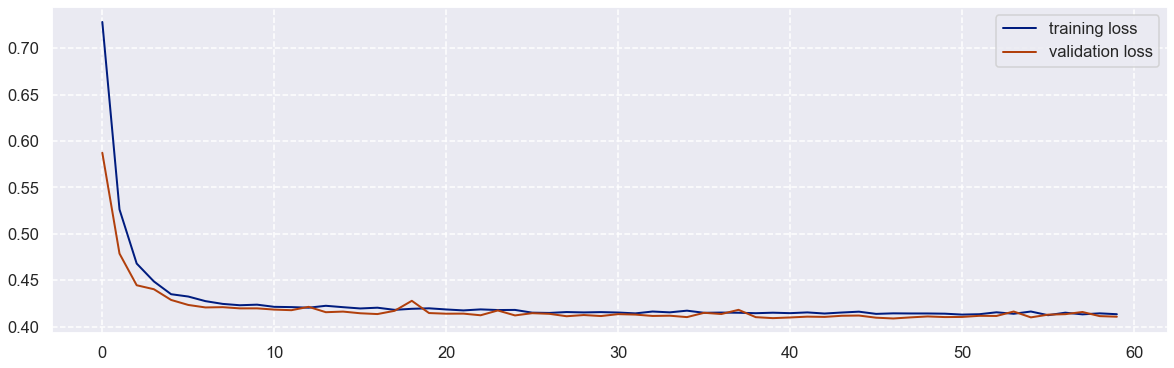

In [326]:
plt.figure(figsize=(20,6))
plt.plot(log5.history['loss'],label = "training loss")
plt.plot(log5.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

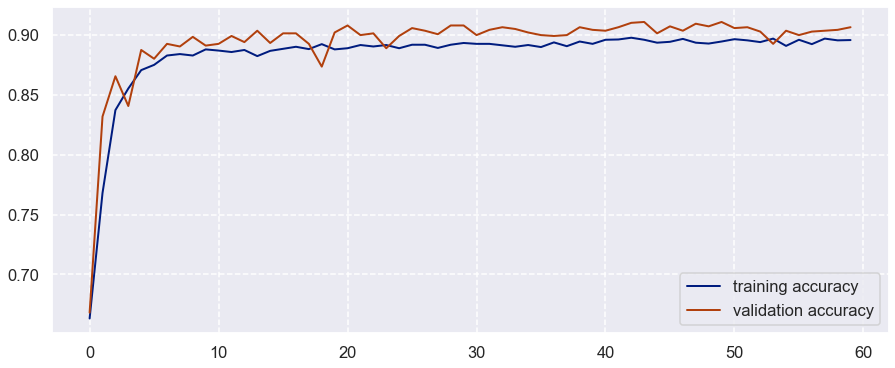

In [327]:
plt.figure(figsize=(15,6))
plt.plot(log5.history['accuracy'],label = "training accuracy")
plt.plot(log5.history['val_accuracy'], label = "validation accuracy")
plt.legend()
plt.show()

In [328]:
# Get th probability of the y label in validation set
y_prob5 = saved_model5.predict(X_valid5)

AUC test:  0.9603355536490616


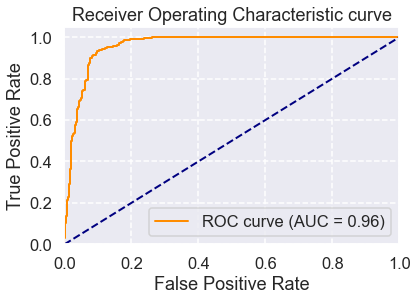

In [329]:
# Draw the ROC curve and calculate AUC score
fpr5, tpr5, thr5 = roc_curve(y_valid5, y_prob5)
roc_auc5 = auc(fpr5, tpr5)
print('AUC test: ', roc_auc5)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr5, tpr5, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc5)
plt.plot([0,1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [330]:
# Find the threshold based on the J statistic
J5 = tpr5 - fpr5
print("The best threshold according to the J statistic is " + str(thr5[np.argmax(J5)]))

# Get the prediction of the y label based on the J statistic in validation dataset
y_predict_valid5= np.where(y_prob5 > thr5[np.argmax(J5)], 1, 0)

# Get the confusion matrix of the prediction within validation dataset
cm5_valid = confusion_matrix(y_valid5, y_predict_valid5)
cm5_valid

The best threshold according to the J statistic is 0.412164


array([[824,  90],
       [ 31, 423]])

In [331]:
# To see the prediction accuracy of the model within test dataset 
TN = cm5_valid[0][0]
FP = cm5_valid[0][1]
FN = cm5_valid[1][0]
TP = cm5_valid[1][1]
# Accuracy of the model5 in validation set
(TP+TN)/(TP+TN+FP+FN)

0.9115497076023392

In [332]:
saved_model5.evaluate(X_test5, y_test5)
print("MSE on test set: " + str(saved_model5.evaluate(X_test5, y_test5)))

72/72 [==============================] - 0s 1ms/step - loss: 0.3352 - accuracy: 0.9171
MSE on test set: [0.3351598381996155, 0.9171006679534912]


In [333]:
# Get the prediction of the y label based on the J statistic in testing set
y_prob_test5 = saved_model5.predict(X_test5)
y_predict_test5= np.where(y_prob_test5 > thr5[np.argmax(J5)], 1, 0)
cm5_test = confusion_matrix(y_test5, y_predict_test5)
cm5_test

array([[2011,  270],
       [   8,   15]])

In [334]:
# To see the prediction accuracy of the model within test dataset 
TN = cm5_test[0][0]
FP = cm5_test[0][1]
FN = cm5_test[1][0]
TP = cm5_test[1][1]

(TP+TN)/(TP+TN+FP+FN)

0.8793402777777778

In [ ]:
from sklearn.metrics import roc_auc_score
roc_test5 = roc_auc_score(y_test5,y_predict_test5)
roc_test5 

# Q6. Creating Dataset Used For Autoencoder Approach

For the Autoencoder approach, we have to split the original dataset into three parts: training, validation and test set. In this case, in the training set, we will only include non-fraudulent observations, whereas in the validation and test set, we will include both classes. We want the model firstly to train and reproduce properly the non-fraudulent observations, and then use the validation set to evaluate the performance of the train model, by assessing the detection of anomal data (fraud cases) in the validation set. Once decided the model, we will apply it to the test set for prediction. In terms of the number of fradulent cases, it will be equally distributed between validation and test.

In [99]:
# Split df_fraud dataset into two subsets
y_fraud= df[df['Fraud'] ==1]['Fraud']
X_fraud = df[df['Fraud'] ==1].drop(columns= ['Fraud','PolicyholderNumber'])
X_valid_fraud, X_test_fraud, y_valid_fraud, y_test_fraud = train_test_split(
    X_fraud,y_fraud,test_size = 0.5, random_state = 888)

In [100]:
# Split df_nonfraud dataset into three subsets
y_nonfraud = df[df['Fraud'] ==0]['Fraud']
X_nonfraud = df[df['Fraud'] ==0].drop(columns= ['Fraud','PolicyholderNumber'])

X_train6, X_other_nonfraud, y_train6, y_other_nonfraud = train_test_split(
    X_nonfraud,y_nonfraud,test_size = 0.4, random_state = 888)

X_valid_nonfraud, X_test_nonfraud, y_valid_nonfraud, y_test_nonfraud = train_test_split(
    X_other_nonfraud,y_other_nonfraud,test_size = 0.5, random_state = 888)


In [101]:
# Concat fraud and non-fraud subsets as validation and test datasets
X_valid6 = pd.concat([X_valid_fraud,X_valid_nonfraud])
X_test6 = pd.concat([X_test_fraud, X_test_nonfraud])

y_valid6 = pd.concat([y_valid_fraud,y_valid_nonfraud])
y_test6 = pd.concat([y_test_fraud,y_test_nonfraud])

# Q7. Using TensorFlow to Create Autoencoder (Model 7)


Once the dataset is ready, we have to scale the variables before implementing the model. 
In this case, the model will have two hidden layers in the encoder part, as well as the decoder part. The hyperparameters for the model are set to a range, which through Hyperband tuner object, we will find the best parameters.


Model 7 parameters:
- Number of neurons in the input layer: 69
- Number of neurons in the first hidden layer: 62
- Number of neurons in the second hidden layer: 18
- Number of hidden layers in encoder and decoder: 2
- Number of neurons in the output layer: 1
- Optimizer: Adam, Learning rate: 0.001963


From the results obtained in the training phase, we could foresee that the model is not predicting at outstading level, since the mean squared error (MSE) between training and validation is not highly differentiate, meaning that, the model is not sensible to detect the anomal data from the validation set (the fraud cases). In this model, we have used two different approaches to determine the threshold, according to the mean squared error and the J-statistics, therefore, we will obtain two accuracy rates. For the prediction performance of the model decided by MSE, we obtained an accuracy of 67%, whereas for the one decided with J-statistics, we could reached to 88% with an AUC of 67%. However, it is relevant to consider that the metrics obtained are from an imbalanced dataset with few fraud cases, which might lead to a high accuracy rate. 

The model can still be improved in terms of prediction performance, especially if the imbalance between classes can be solved. In this case, one of the options could be proceed the SMOTE approach that we mentioned in Model 5, as well as, setting an initial bias into the model to reduce the initial loss. This would allow the model to not spend the first few epochs to learn that positive results are unlikely. Another approach could be passing Keras weights for each class through a parameter so that the under-represented class can weight heavier and be more relevant when processing the model.

Another way to improve the performance of the model could be by trying more combinations between the hyperparameters in order to make the model learn more regarding the features of non-fraudulent cases so that it can detect better the anomal case of fradulent, so that the threshold line can different clearly between classes.

In [450]:
# Scale X-training data and then use the same scaler to valid and test dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train6 = scaler.fit_transform(X_train6)
X_valid6 = scaler.fit_transform(X_valid6)
X_test6 = scaler.transform(X_test6)

In [497]:
# clear TensorFlow session
from tensorflow.keras.layers import Dense
tf.keras.backend.clear_session()
np.random.seed(888)
tf.random.set_seed(888)

In [498]:
# Define function for training autoencoder model
def train_autoencoder(hp):    
    num_units = hp.Int('num_units', min_value = 50, max_value= 69)
    num_units2 = hp.Int('num_units2', min_value = 5, max_value=20)

    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.01, sampling='log') 
    
    reg_param = 0.01
    regularizer = tf.keras.regularizers.l2(reg_param)

    encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(num_units, activation="relu"), 
    tf.keras.layers.Dense(num_units2, activation="relu")
    
    ])

    decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(num_units2, activation="relu"), 
    tf.keras.layers.Dense(69, activation="sigmoid")]) 
    
    autoencoder = tf.keras.Sequential([encoder,decoder])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
       
    
    autoencoder.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.MeanSquaredError())
    
    return autoencoder

In [499]:
# Generate the `Hyperband` tuner object and search through the space of hyperparameters
tuner7 = kt.Hyperband(train_autoencoder,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='logs3',
                     project_name='kt_autoencoder')  

In [ ]:
#%% clear out the folder
rm -rf ./logs3/kt_autoencoder

In [500]:
tuner7.search(X_train6,X_train6,validation_data=(X_valid6,X_valid6))

Trial 90 Complete [00h 00m 16s]
val_loss: 0.22154706716537476

Best val_loss So Far: 0.006974291056394577
Total elapsed time: 00h 07m 58s
INFO:tensorflow:Oracle triggered exit


In [501]:
best_hps7 = tuner7.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps7['learning_rate']))
print("Best number of hidden units: " + str(best_hps7['num_units']))
print("Best number of hidden units: " + str(best_hps7['num_units2']))
print("Best number optimizer: " + str(best_hps7['optimizer']))


Best learning rate: 0.001963620627045603
Best number of hidden units: 62
Best number of hidden units: 18
Best number optimizer: adam


In [502]:
best_autoencoder = tuner7.hypermodel.build(best_hps7)

In [503]:
# Train the model
log7 = best_autoencoder.fit(x=X_train6, y=X_train6,
                epochs=40,
                validation_data=(X_valid6, X_valid6))

Epoch 1/40
214/214 [==============================] - 1s 2ms/step - loss: 0.0642 - val_loss: 0.0266
Epoch 2/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0183
Epoch 3/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 4/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 5/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 6/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 7/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 8/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 9/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 10/40
214/214 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0102

In [528]:
#best_autoencoder.save("my_tf_best_model7_2.h5") 

In [529]:
saved_model7 = tf.keras.models.load_model("my_tf_best_model7_2.h5")

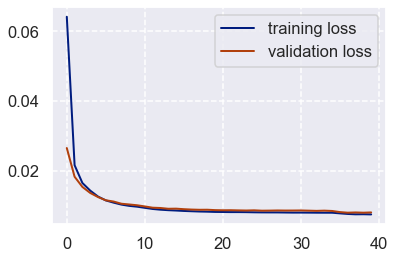

In [507]:
sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
plt.plot(log7.history['loss'],label = "training loss")
plt.plot(log7.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [508]:
# Using the best autoencoder model to predict the X features within validaition set
X_feature7 = saved_model7.predict(X_valid6)

In [509]:
# For each observation, measure the difference between the original x features and the prediction one by using the mean square error 
mse7 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(
    X_valid6, X_feature7).numpy()

In [510]:
# Get the average of mean squared error within the validation set and then setting it as the threshold
from sklearn.metrics import mean_squared_error
k7 = mean_squared_error(X_valid6,X_feature7)
y_label7 = y_valid6.apply(lambda x: "Fraud" if (x == 1) else "Non-Fraud" )

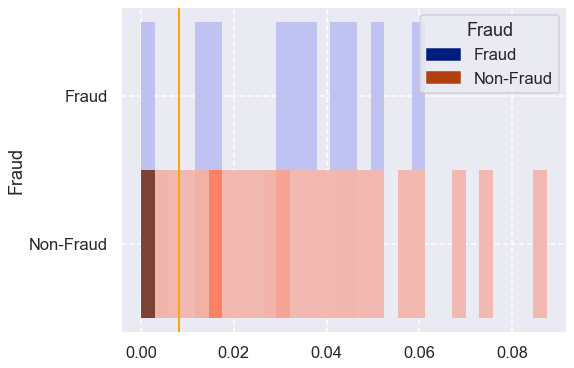

In [511]:
# Plot the mean squared errors for all validation set in a histogram
plt.figure(figsize=(8, 6))
sns.histplot(
    x=mse7, y=y_label7, hue = y_label7, legend=True, bins = 30
)
# draw the clearly marking
plt.axvline(x=k7, color='orange') 

In [512]:
# Using the threshold to predict the y label in validation set
y_predict_valid8 = np.where(mse7 > k7, 1, 0)
cm8_valid = confusion_matrix(y_valid6, y_predict_valid8)
cm8_valid

array([[1496,  785],
       [  27,   30]])

In [513]:
# Get the confusion matrix of the validation set 
TN = cm8_valid[0][0]
FP = cm8_valid[0][1]
FN = cm8_valid[1][0]
TP= cm8_valid[1][1]

## Get the accuracy of the Model7 used within the validation set
(TP+TN)/(TP+TN+FP+FN)  # 0.7523

0.6526946107784432

# Q8. Train Autoencoder to Predict the Test Set

## Q8.1 Setting the threshold by using mean squared error

In [514]:
# Using the best autoencoder model to predict the X features within teset set
x_feature8 = saved_model7.predict(X_test6)

In [515]:
# For each observation, measure the difference between the original x features and the prediction one by using the mean square error 
mse8 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(X_test6, x_feature8).numpy()
k8 = np.mean(mse8 )   

y_label8 = y_test6.apply(lambda x: 'Fraud' if x == 1 else 'Non-Fraud' )


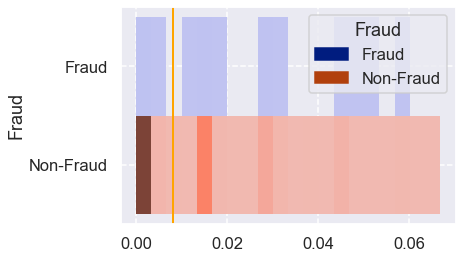

In [516]:
# Plot histogram of test set claims
sns.histplot( x= mse8, y= y_label8, hue = y_label8, bins = 20,legend = True)
plt.axvline(x=k8,color='orange') #clearly marking 

In [517]:
# Using the threshold to predict the y label in test set
y_predict8= np.where(mse8 > k8, 1, 0)
cm8 = confusion_matrix(y_test6, y_predict8)
cm8

array([[1539,  742],
       [  24,   34]])

In [518]:
# Get the confusion matrix of the test set 
TN_8 = cm8[0][0]
FP_8 = cm8[0][1]
FN_8 = cm8[1][0]
TP_8= cm8[1][1]

## Get the accuracy of the Model7 used within the test set
(TP_8+TN_8)/(TP_8+TN_8+FP_8+FN_8)

0.6725096194955109

## Q8.2 Setting threshold by using J statistic

AUC test:  0.6316404777836744


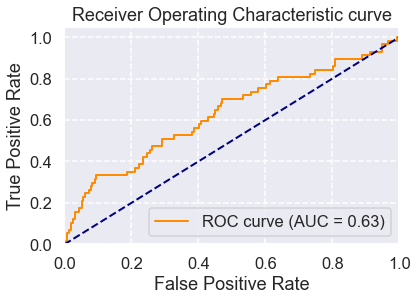

In [519]:
fpr7, tpr7, thr7 = roc_curve(y_valid6, mse7)
roc_auc7 = auc(fpr7, tpr7)
print('AUC test: ', roc_auc7)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr7, tpr7, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc7)
plt.plot([0,1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [530]:
#%% find threshold
J7 = tpr7 - fpr7
print('The best threshold according to the J statistic is '+ str(thr7[np.argmax(J7)]))

The best threshold according to the J statistic is 0.029227952


In [521]:
# Get the prediction of the validation set based on J statistic threshold
y_predict_valid7 = np.where(mse7 > thr7[np.argmax(J7)],1,0)
y_predict_valid7

array([0, 0, 0, ..., 0, 0, 0])

In [522]:
# To see the confusion matrix of validation set
cm7_valid = confusion_matrix(y_valid6, y_predict_valid7)
cm7_valid

array([[2064,  217],
       [  39,   18]])

In [523]:
# To see model7 accuracy within validation set
TN = cm7_valid[0][0]
FP = cm7_valid[0][1]
FN = cm7_valid[1][0]
TP = cm7_valid[1][1]

(TP+TN)/(TP+TN+FP+FN)

0.8905047048759623

In [524]:
# Predict on the test set
# Use save model7 to predict X features
x_feature_test = saved_model7.predict(X_test6)

# Calculate the MeanSquaredError between X test and X-features within each observation 
mse_test = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(X_test6, x_feature_test).numpy()

k_test = np.mean(mse_test)  

# Prediction on y label within test set
y_predict_test7 = np.where( mse_test > thr7[np.argmax(J7)],1,0 )


In [525]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test6,mse8)

0.674038912152867

In [526]:
# Get the confusion matrix within test set
cm7_test = confusion_matrix(y_test6,y_predict_test7)
print(cm7_test)

[[2058  223]
 [  42   16]]


In [527]:
# Get the confusion matrix within test set
TN = cm7_test[0][0]
FP = cm7_test[0][1]
FN = cm7_test[1][0]
TP= cm7_test[1][1]

# Accuracy of the model7
(TP+TN)/(TP+TN+FP+FN)

0.8867037195382642

# Q9. Drawback of Neural Network

Neural networks are used to make predictions, since their prediction performance and accuracy can reach to high levels when the designed model is good, compared with other classifier methods. However, the main downside of using neural network is that it is hard to interpret and understand the prediction process of the model, since they act like "Black Boxes" where we introduce all the inputs to the machine and it provides us the required output, without knowing what happened in the middle process. 

Applying the process to our case will lead to the situation that the insurance company agents will not be able to explain in details to the clients the reason why their claims have been investigated as fraud suspicious. The main inputs are data that the company has collected regarding the incidence occured but they do not know which part of this information has led to the fraud investigation, neither the threshold that limit the claims to be considered as fraudulent or not fradulent. This lack of transparency of the decision-making process of the company  can cause  complaints and distrust of the clients, since no reasonable nor detail explanations were able to be given, which might end up affecting the business reputation.

There are other classifier methods which the prediction performance might not be as outstanding as neural network, but they are more transparent and easier to interpret the decision-making process, such as decision tree or random forest, among others. For instance, decision tree approach allows the agents of the insurance company to know clearly which part of the information from the claim has led to different outcomes through graphical representation and the clients will also be able to have a better understanding of the whole process.


# Q10. Comparing with Decision Tree

We have decided to use Decision Tree method to classify the claims of the clients and provide the interpretation of the decision-making process. We have chosen the synthetic dataset that we have used in Model 5, where the test set was the original one. 

We built the decision tree with a maximum of 4 leaf nodes, in order to avoid the tree being too large, which will complicate the interpretation of the prediction as well. After the visual representation of the decision tree, we computed the accuracy and the AUC score of the model on the test set, which gave us the result of 87% and 0.76, respectively. In terms of the performance, it is quite similar to the results from Model 5 and better than Model 3 and 7. However, one of the drawbacks of using decision tree to classify is that the approach highly depends on the training data, meaning that, if we resample the training set, we might get completely different results and accuracy level. 

In terms of the interpretability of the decision tree model, by looking at the graphical representation, we could derive to the reason why the claim of customers has been classified as suspicious of fraud, as well as which are the variables that the model gives more importance when classifying. For instance, if the variable "ActLiability", which is one type of the insurance covers that holders have used, presents a value less than 0.005 then, with high probability and node purity that the claim of the client will be classified as fraud suspicious. Therefore, by looking at the graphical representation, the agents of insurance company would be able to explain to clients when asking for the reason of fraud investigation.

In [29]:
from sklearn.tree import DecisionTreeClassifier
import graphviz as gp
from sklearn.tree import export_graphviz

In [30]:
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 4)
clf = classifier_DT.fit(X_train5, y_train5.values.ravel())

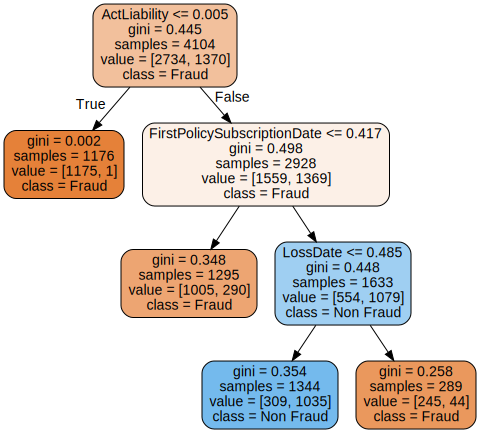

In [31]:
dot_data = export_graphviz(classifier_DT, feature_names = X.columns, filled = True, rounded = True, class_names=["Fraud","Non Fraud"])
graph = gp.Source(dot_data)
graph

In [32]:
# The probability of Fraud on the validation set
Y_probs_tree=classifier_DT.predict_proba(X_valid5)[:,1]

AUC test:  0.8486514232834326


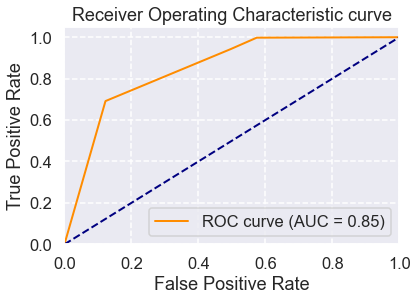

In [33]:
from matplotlib import pyplot
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_valid5,Y_probs_tree)
roc_auc_t = auc(fpr_t, tpr_t)
print('AUC test: ', roc_auc_t)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr_t, tpr_t, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc_t)
plt.plot([0,1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()


In [34]:
#%% Setting threshold and get the Confusion Matrix in Validation Set 
from sklearn.metrics import confusion_matrix
J_t = tpr_t - fpr_t
thr_t = thresholds_t[np.argmax(J_t)]
y_predict_valid = np.where(Y_probs_tree >= thr_t, 1, 0)
y_predict_valid
print("The best threshold according to the J statistic is " + str(thresholds_t[np.argmax(J_t)]))

The best threshold according to the J statistic is 0.7700892857142857


In [35]:
cm_valid = confusion_matrix(y_valid5,y_predict_valid)
TN_valid = cm_valid[0][0]
FP_valid = cm_valid[0][1]
FN_valid = cm_valid[1][0]
TP_valid = cm_valid[1][1]
(TP_valid + TN_valid)/(TP_valid +TN_valid + FP_valid + FN_valid )

# model in validation set acc is 0.8157894736842105

0.8157894736842105

In [36]:
Y_probs_test=classifier_DT.predict_proba(X_test5)[:,1]
y_predict_test = np.where(Y_probs_test >= thr_t, 1, 0)

In [37]:
cm_test = confusion_matrix(y_test5, y_predict_test)
cm_test

array([[1994,  287],
       [   8,   15]])

In [274]:
TN_test = cm_test[0][0]
FP_test = cm_test[0][1]
FN_test = cm_test[1][0]
TP_test= cm_test[1][1]

# Accuracy of the Decision Tree
(TP_test + TN_test )/(TP_test + TN_test + FP_test + FN_test )

0.8719618055555556

In [38]:
from sklearn.metrics import roc_auc_score
roc_test = roc_auc_score(y_test5,y_predict_test)
roc_test


0.7631759525761013